# Image processing classes

In [20]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score
from scipy import ndimage

class CellAugmentator:
    """Класс для аугментации клеток перед вставкой на фон"""
    @staticmethod
    def augment_cell(cell_img):
        # Случайное изменение яркости
        cell_img = cv2.convertScaleAbs(cell_img, alpha=random.uniform(0.7, 1.3))
        
        # Случайный поворот
        angle = random.randint(-45, 45)
        h, w = cell_img.shape[:2]
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
        cell_img = cv2.warpAffine(cell_img, M, (w, h))
        
        return cell_img

class BloodCellsDataset(Dataset):
    """Генератор синтетических изображений клеток крови с храниением меток"""
    def __init__(self, fon_path, patch_path, mode="generated", dataset_size=10):
        self.mode = mode
        self.dataset_size = dataset_size
        self.images = []
        self.true_counts = []
        
        self.fon_images = [cv2.imread(os.path.join(fon_path, f)) 
                          for f in os.listdir(fon_path) if f.endswith('.png')]
        self.patch_images = [cv2.imread(os.path.join(patch_path, f)) 
                           for f in os.listdir(patch_path) if f.endswith('.png')]

        if mode == "generated":
            self._generate_dataset()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.true_counts[idx]

    def _generate_dataset(self):
        for _ in range(self.dataset_size):
            img, count = self._generate_image()
            self.images.append(img)
            self.true_counts.append(count)

    def _generate_image(self):
        background = random.choice(self.fon_images).copy()
        img = background.copy()
        num_cells = random.randint(5, 15)
        
        for _ in range(num_cells):
            cell = random.choice(self.patch_images)
            cell = CellAugmentator.augment_cell(cell)
            cell = cv2.resize(cell, (random.randint(20, 50), random.randint(20, 50)))
            
            # Проверка на перекрытие
            for attempt in range(10):
                x = random.randint(0, img.shape[1] - cell.shape[1])
                y = random.randint(0, img.shape[0] - cell.shape[0])
                roi = img[y:y+cell.shape[0], x:x+cell.shape[1]]
                
                if np.mean(roi) < 200:  # Проверка на перекрытие с другими клетками
                    img[y:y+cell.shape[0], x:x+cell.shape[1]] = cell
                    break
                    
        return img, num_cells

class Segmentator:
    """Базовый класс для алгоритмов сегментации"""
    def process(self, image):
        raise NotImplementedError

class HoughSegmentator(Segmentator):
    """Сегментация методом кругов Хафа"""
    def __init__(self, dp=1.2, min_dist=20, param1=50, param2=30, radii_range=(10,40)):
        self.params = {
            'dp': dp,
            'minDist': min_dist,
            'param1': param1,
            'param2': param2,
            'minRadius': radii_range[0],
            'maxRadius': radii_range[1]
        }

    def process(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.medianBlur(gray, 5)
        circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, **self.params)
        
        output = image.copy()
        count = 0
        
        if circles is not None:
            circles = np.uint16(np.around(circles))
            for i in circles[0, :]:
                cv2.circle(output, (i[0], i[1]), i[2], (0, 255, 0), 2)
                count += 1
                
        return output, count

class WatershedSegmentator(Segmentator):
    """Сегментация методом водораздела"""
    def process(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        # Удаление шумов
        kernel = np.ones((3,3), np.uint8)
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
        
        # Поиск областей фона
        sure_bg = cv2.dilate(opening, kernel, iterations=3)
        
        # Поиск гарантированных областей переднего плана
        distance = ndimage.distance_transform_edt(opening)
        _, sure_fg = cv2.threshold(distance, 0.5*distance.max(), 255, 0)
        sure_fg = sure_fg.astype(np.uint8)
        
        # Поиск неизвестной области
        unknown = cv2.subtract(sure_bg, sure_fg)
        
        # Маркировка меток
        _, markers = cv2.connectedComponents(sure_fg)
        markers += 1
        markers[unknown == 255] = 0
        
        # Применение алгоритма водораздела
        markers = cv2.watershed(image, markers)
        
        output = image.copy()
        output[markers == -1] = [0, 0, 255]
        return output, len(np.unique(markers)) - 2  # Вычитаем фон и неизвестную область

class SegmentationEvaluator:
    """Класс для оценки качества сегментации"""
    @staticmethod
    def evaluate(true_counts, predicted_counts):
        metrics = {
            'accuracy': accuracy_score(true_counts, predicted_counts),
            'precision': precision_score(true_counts, predicted_counts, 
                                       average='macro', zero_division=1)
        }
        return metrics

class DatasetVisualizer:
    """Класс для визуализации результатов сегментации"""
    @staticmethod
    def visualize_sample(original, hough_img, hough_count, watershed_img, watershed_count, true_count):
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title(f"Original\nTrue cells: {true_count}")
        
        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(hough_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Hough Circles\nDetected: {hough_count}")
        
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(watershed_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Watershed\nDetected: {watershed_count}")
        
        plt.tight_layout()
        plt.show()

class SegmentationTester:
    """Основной класс для тестирования алгоритмов"""
    def __init__(self, dataset):
        self.dataset = dataset
        self.hough = HoughSegmentator()
        self.watershed = WatershedSegmentator()
        self.visualizer = DatasetVisualizer()
        self.evaluator = SegmentationEvaluator()

    def run_test(self):
        hough_counts = []
        watershed_counts = []
        true_counts = []

        for img, true_count in self.dataset:
            hough_img, hough_count = self.hough.process(img)
            watershed_img, watershed_count = self.watershed.process(img)
            
            hough_counts.append(hough_count)
            watershed_counts.append(watershed_count)
            true_counts.append(true_count)
            
            self.visualizer.visualize_sample(
                img, hough_img, hough_count, 
                watershed_img, watershed_count, true_count
            )

        print("\nHough Method Metrics:")
        print(self.evaluator.evaluate(true_counts, hough_counts))
        
        print("\nWatershed Method Metrics:")
        print(self.evaluator.evaluate(true_counts, watershed_counts))

# Run

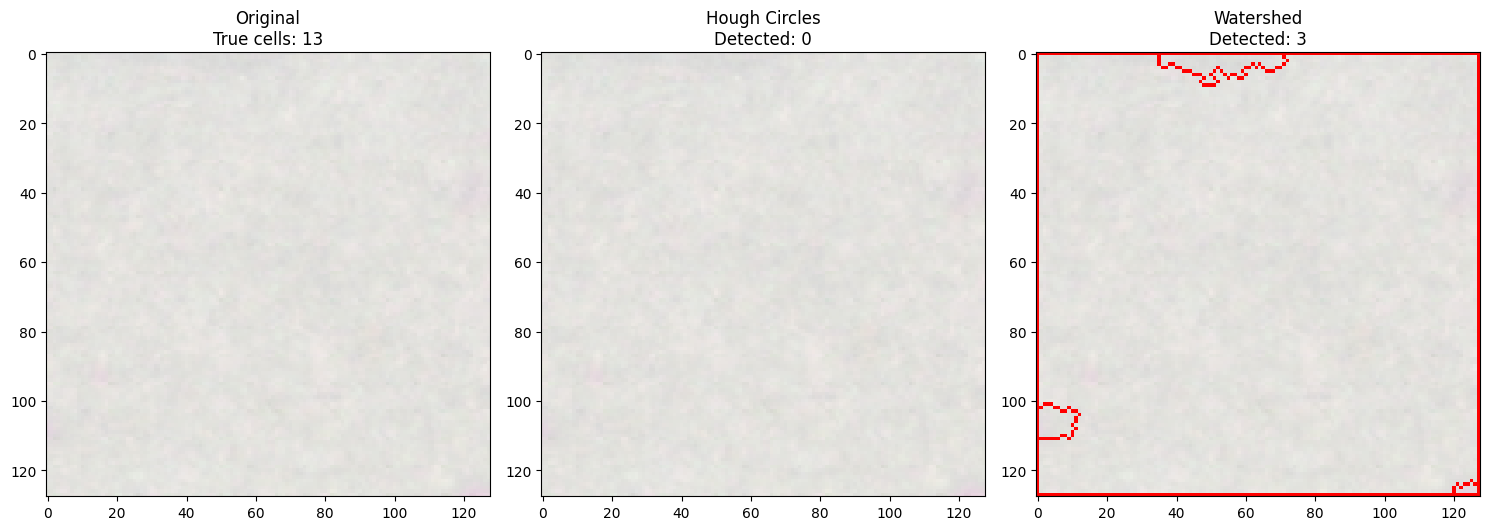

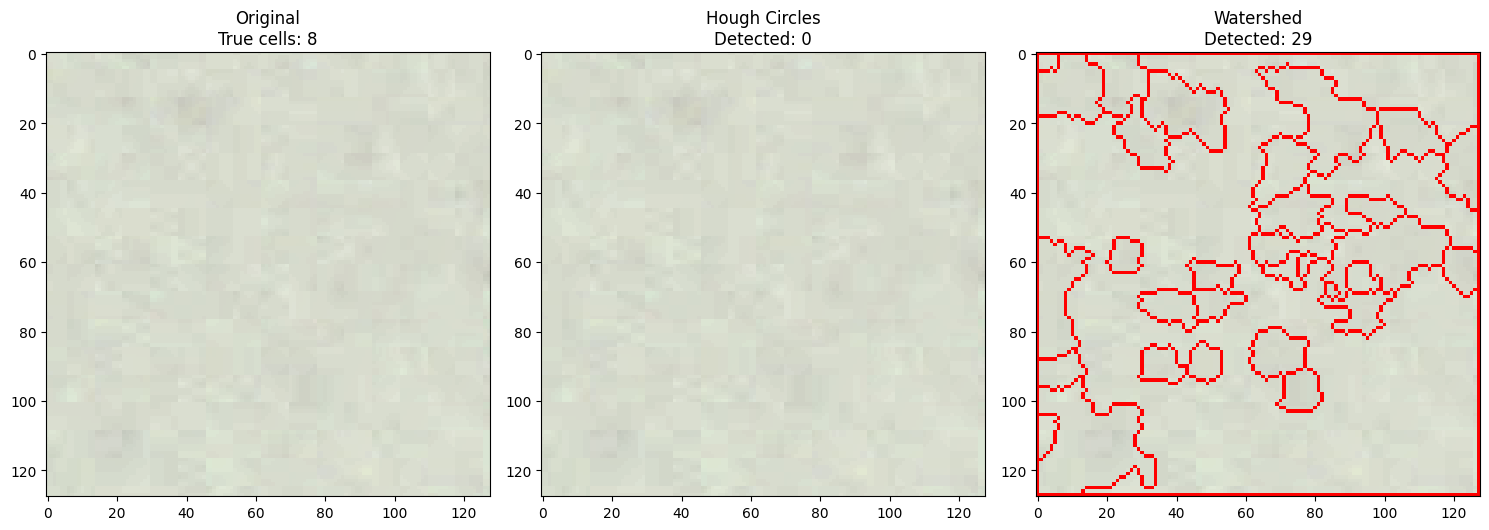

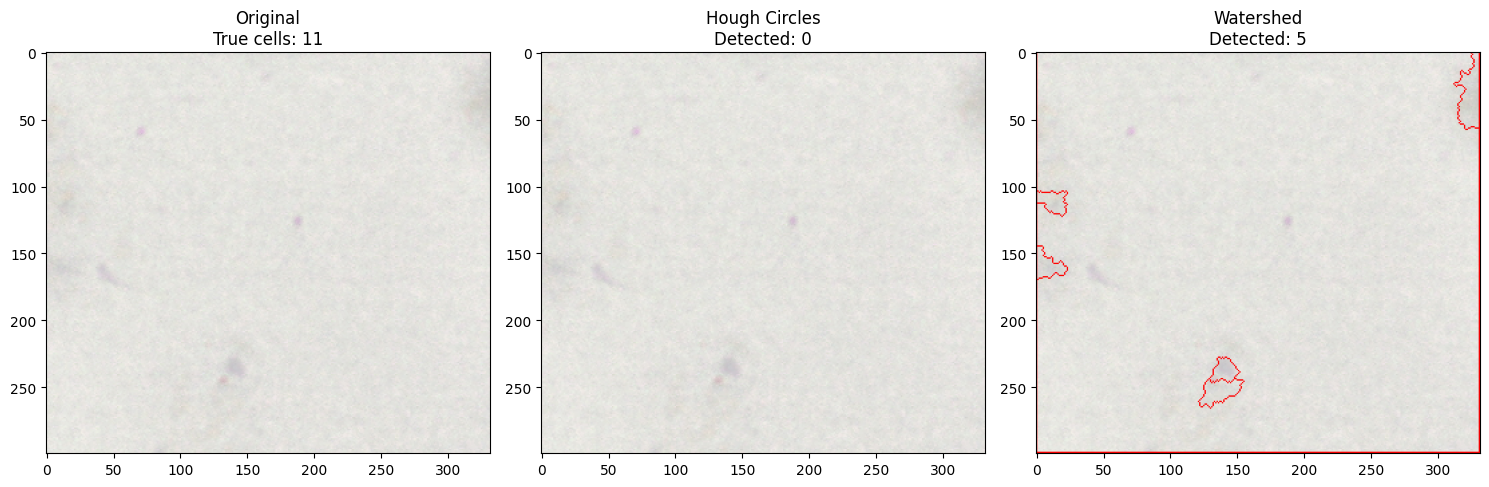

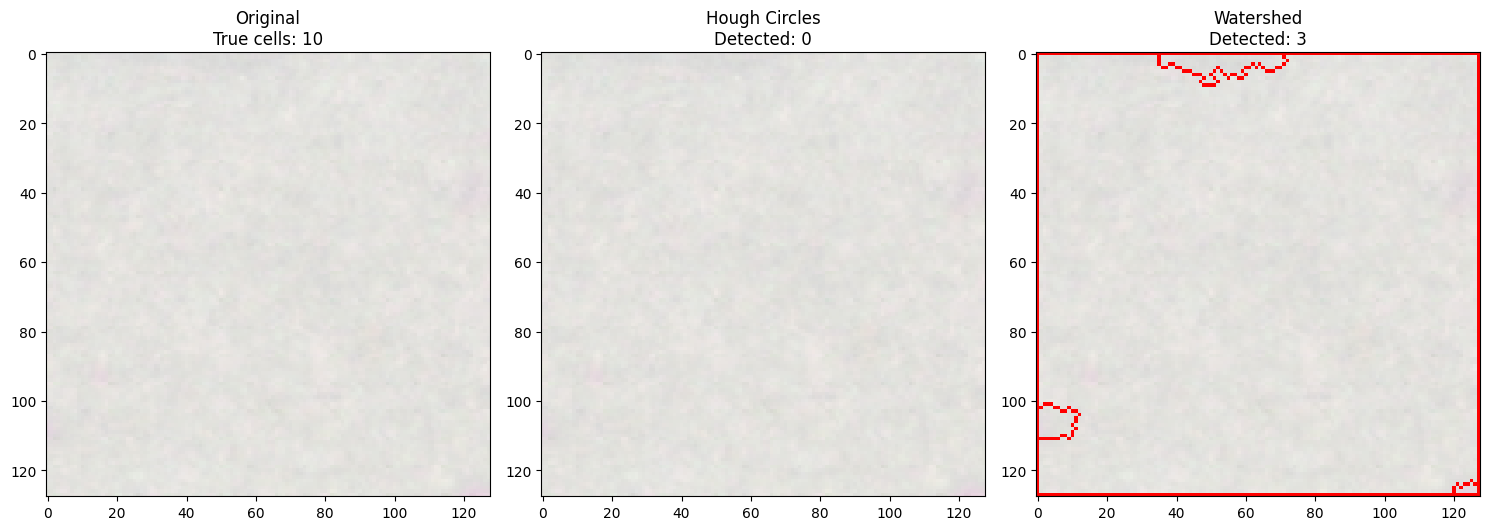

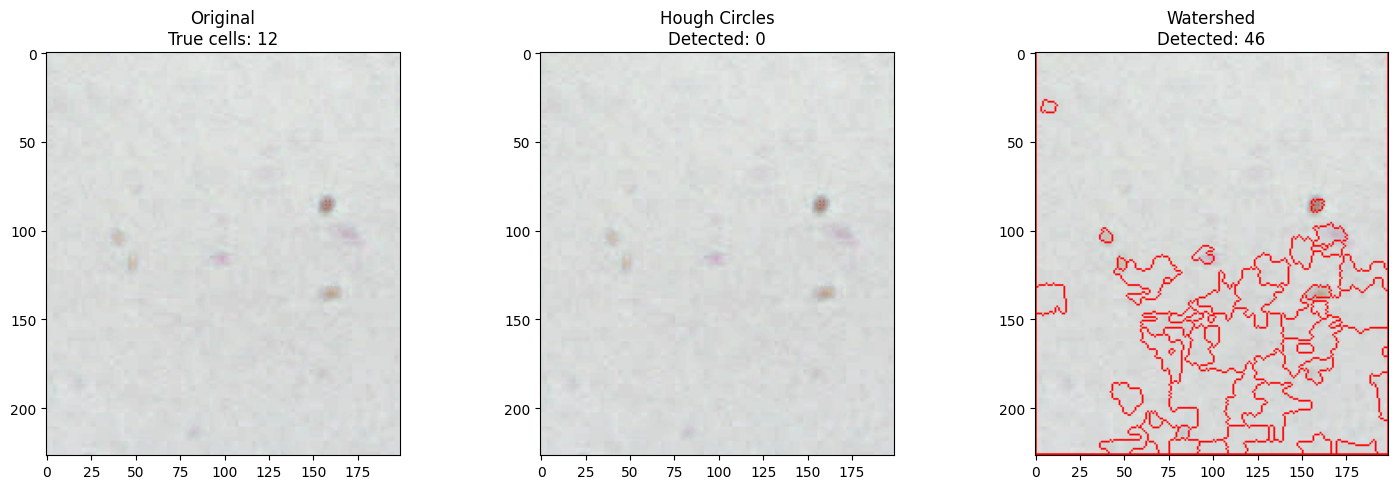


Hough Method Metrics:
{'accuracy': 0.0, 'precision': 0.8333333333333334}

Watershed Method Metrics:
{'accuracy': 0.0, 'precision': 0.5555555555555556}


In [21]:
if __name__ == "__main__":
    # Инициализация датасета
    dataset = BloodCellsDataset(
        fon_path="blood_cells_dataset/fon/",
        patch_path="blood_cells_dataset/patch/",
        dataset_size=5
    )

    # Запуск тестирования
    tester = SegmentationTester(dataset)
    tester.run_test()